Epoch vs validation correlation (Step 3)

Copy of train_cnn_shifter_table_1. This notebook adds per-epoch validation correlation and plots epoch vs mean correlation (validation set). Run a single config below and then the plotting cell.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, ConcatDataset
from mouse_model.data_utils_new import MouseDatasetSegNewBehav
import numpy as np
from mouse_model.evaluation import cor_in_time
import random, os
from kornia.geometry.transform import get_affine_matrix2d, warp_affine
import matplotlib.pyplot as plt

In [3]:
class Shifter(nn.Module):
    def __init__(self, input_dim=4, output_dim=3, hidden_dim=256):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh(),
        )
        self.bias = nn.Parameter(torch.zeros(3))
    def forward(self, x):
        x = x.reshape(-1,self.input_dim )
        x = self.layers(x)
        x0 = (x[...,0] + self.bias[0]) * 80/4
        x1 = (x[...,1] + self.bias[1]) * 60/4
        x2 = (x[...,2] + self.bias[2]) * 180/4
        x = torch.stack([x0, x1, x2], dim=-1)
        x = x.reshape(-1,1,self.output_dim)
        return x

In [4]:
# useful for printing in nn.Sequential
class PrintLayer(nn.Module):
    
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

def size_helper(in_length, kernel_size, padding=0, dilation=1, stride=1):
    # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
    res = in_length + 2 * padding - dilation * (kernel_size - 1) - 1
    res /= stride
    res += 1
    return np.floor(res)

# CNN, the last fully connected layer maps to output_dim
class VisualEncoder(nn.Module):
    
    def __init__(self, output_dim, input_shape=(60, 80), k1=7, k2=7, k3=7):
        
        super().__init__()
        
        self.input_shape = (60, 80)
        out_shape_0 = size_helper(in_length=input_shape[0], kernel_size=k1, stride=2)
        out_shape_0 = size_helper(in_length=out_shape_0, kernel_size=k2, stride=2)
        out_shape_0 = size_helper(in_length=out_shape_0, kernel_size=k3, stride=2)
        out_shape_1 = size_helper(in_length=input_shape[1], kernel_size=k1, stride=2)
        out_shape_1 = size_helper(in_length=out_shape_1, kernel_size=k2, stride=2)
        out_shape_1 = size_helper(in_length=out_shape_1, kernel_size=k3, stride=2)
        self.output_shape = (int(out_shape_0), int(out_shape_1)) # shape of the final feature map
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=k1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=k2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=k3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(self.output_shape[0]*self.output_shape[1]*32, output_dim)
        )
        
    def forward(self, x):

        x = self.layers(x)

        return x

In [5]:
class Predictor(nn.Module):
    
    def __init__(self, num_neurons):

        super().__init__()
        
        self.encoder = VisualEncoder(output_dim=num_neurons)
        self.softplus = nn.Softplus()
        self.shifter = Shifter()

    def forward(self, images, behav):
        # print(images.shape)  torch.Size([256, 1, 60, 80])
        if args.shifter:
            bs = images.size()[0]
            behav_shifter = torch.concat((behav[...,4].unsqueeze(-1),   # theta
                                          behav[...,3].unsqueeze(-1),   # phi
                                          behav[...,1].unsqueeze(-1),  # pitch
                                         behav[...,2].unsqueeze(-1),  # roll
                                         ), dim=-1)  
            shift_param = self.shifter(behav_shifter)  
            shift_param = shift_param.reshape(-1,3)
            scale_param = torch.ones_like(shift_param[..., 0:2]).to(shift_param.device)
            affine_mat = get_affine_matrix2d(
                                            translations=shift_param[..., 0:2] ,
                                             scale = scale_param, 
                                             center =torch.repeat_interleave(torch.tensor([[30,40]], dtype=torch.float), 
                                                                            bs*1, dim=0).to(shift_param.device), 
                                             angle=shift_param[..., 2])
            affine_mat = affine_mat[:, :2, :]
            images = warp_affine(images, affine_mat, dsize=(60,80))
        pred = self.encoder(images)
        pred = self.softplus(pred)
        
        return pred

In [6]:
class Args:
    
    seed = 0
    file_id = "070921_J553RT"
    epochs = 100
    batch_size = 256
    seq_len = 1
    num_neurons = 66
    learning_rate = 0.0001
    segment_num = None
    best_train_path = None
    best_val_path = None
    vid_type = None
    shifter = False
    
args=Args()

seed = args.seed
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()
print(torch.cuda.is_available())

True


In [7]:
def load_train_val_ds():
    ds_list = [MouseDatasetSegNewBehav(file_id=args.file_id, segment_num=args.segment_num, seg_idx=i, data_split="train", 
                               vid_type=args.vid_type, seq_len=args.seq_len, predict_offset=1) 
               for i in range(args.segment_num)]
    train_ds, val_ds = [], []
    for ds in ds_list:
        train_ratio = 0.8
        train_ds_len = int(len(ds) * train_ratio)
        train_ds.append(Subset(ds, np.arange(0, train_ds_len, 1)))
        val_ds.append(Subset(ds, np.arange(train_ds_len, len(ds), 1)))
    train_ds = ConcatDataset(train_ds)
    val_ds = ConcatDataset(val_ds)
    print(len(train_ds), len(val_ds))
    return train_ds, val_ds

In [8]:
def load_test_ds():
    test_ds = [MouseDatasetSegNewBehav(file_id=args.file_id, segment_num=args.segment_num, seg_idx=i, data_split="test", 
                               vid_type=args.vid_type, seq_len=args.seq_len, predict_offset=1) 
               for i in range(args.segment_num)]
    test_ds = ConcatDataset(test_ds)
    return test_ds

In [9]:
def train_model():
    
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    
    train_ds, val_ds = load_train_val_ds()

    train_dataloader = DataLoader(dataset=train_ds, batch_size=args.batch_size, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(dataset=val_ds, batch_size=args.batch_size, shuffle=False, num_workers=8)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    best_train_loss = np.inf
    best_val_loss = np.inf
    train_loss_list = []
    val_loss_list = []
    val_cor_list = []
    ct = 0

    # start training
    for epoch in range(args.epochs):

        print("Start epoch", epoch)

        model.train()

        epoch_train_loss = 0

        for (image, behav, spikes) in train_dataloader:

            image, behav, spikes = image.to(device), behav.to(device), spikes.to(device)
            image = torch.squeeze(image, axis=1)

            pred = model(image, behav)
            
            loss = nn.functional.poisson_nll_loss(pred, spikes, reduction='mean', log_input=False)

            epoch_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_train_loss = epoch_train_loss / len(train_dataloader)

        train_loss_list.append(epoch_train_loss)

        if epoch_train_loss < best_train_loss:
            

            torch.save(model.state_dict(), args.best_train_path)
            best_train_loss = epoch_train_loss

        print("Epoch {} train loss: {}".format(epoch, epoch_train_loss))

        model.eval()

        epoch_val_loss = 0
        pred_val_all = []
        label_val_all = []

        with torch.no_grad():      

            for (image, behav, spikes) in val_dataloader:

                image, behav, spikes = image.to(device), behav.to(device), spikes.to(device)
                image = torch.squeeze(image, axis=1)

                pred = model(image, behav)

                loss = nn.functional.poisson_nll_loss(pred, spikes, reduction='mean', log_input=False)

                epoch_val_loss += loss.item()
                pred_val_all.append(pred.cpu().numpy())
                label_val_all.append(spikes.cpu().numpy())

        epoch_val_loss = epoch_val_loss / len(val_dataloader)

        val_loss_list.append(epoch_val_loss)

        pred_val = np.concatenate(pred_val_all, axis=0)
        label_val = np.concatenate(label_val_all, axis=0)
        cor_array = cor_in_time(pred_val, label_val)
        mean_cor = np.mean(cor_array)
        val_cor_list.append(mean_cor)
        print("Epoch {} val mean correlation: {:.4f}".format(epoch, mean_cor))

        if epoch_val_loss < best_val_loss:

            torch.save(model.state_dict(), args.best_val_path)
            best_val_loss = epoch_val_loss
            ct = 0
        else: 
            ct += 1
            if ct > 5:
                print('stop training')
                break

        print("Epoch {} val loss: {}".format(epoch, epoch_val_loss))

        print("End epoch", epoch)
        
    return train_loss_list, val_loss_list, val_cor_list

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Single config for a clear epoch-vs-correlation curve (change file_id / shifter / vid_type as needed)
segment_num = 10
file_id, num_neurons = "070921_J553RT", 68
shifter = True
vid_type = "vid_mean"

print(segment_num, vid_type)
print(file_id, "shifter:", shifter)

model = Predictor(num_neurons=num_neurons).to(device)
args.file_id = file_id
args.num_neurons = num_neurons
args.shifter = shifter
args.segment_num = segment_num
args.vid_type = vid_type
args.best_train_path = "/home/herbelinluke/Downloads/trainCNNshifter_epoch_vs_score_train.pth"
args.best_val_path = "/home/herbelinluke/Downloads/valCNNshifter_epoch_vs_score_val.pth"

train_loss_list, val_loss_list, val_cor_list = train_model()

10 vid_mean
070921_J553RT shifter: True
30120 7540
Start epoch 0
Epoch 0 train loss: 0.74874011540817


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

NameError: name 'val_cor_list' is not defined

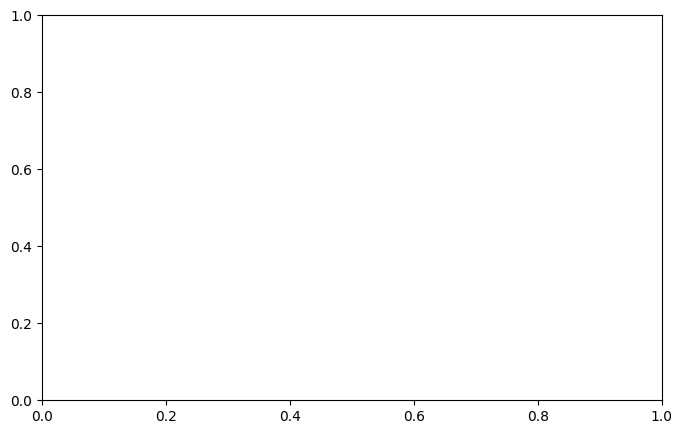

In [11]:
# Plot epoch vs mean validation correlation (neural activity prediction score)
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(len(val_cor_list))
ax1.plot(epochs, val_cor_list, 'b-', label='Mean correlation (val)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean correlation (val)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(epochs, train_loss_list[:len(epochs)], 'gray', alpha=0.7, label='Train loss')
ax2.plot(epochs, val_loss_list, 'orange', alpha=0.7, label='Val loss')
ax2.set_ylabel('Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')
plt.title('Epoch vs validation correlation and loss')
fig.tight_layout()
plt.show()

eval

In [28]:
# default is smoothing with 2 second, 48 ms per frame
def smoothing_with_np_conv(nsp, size=int(2000/48)):
    np_conv_res = []
    for i in range(nsp.shape[1]):
        np_conv_res.append(np.convolve(nsp[:, i], np.ones(size)/size, mode="same"))        
    np_conv_res = np.transpose(np.array(np_conv_res))
    return np_conv_res

In [29]:
def evaluate_model(model, weights_path, dataset, device):

    dl = DataLoader(dataset=dataset, batch_size=256, shuffle=False, num_workers=4)
    
    model.load_state_dict(torch.load(weights_path))

    ground_truth_all = []
    pred_all = []
    
    model.eval()
    
    with torch.no_grad():      
        
        for (image, behav, spikes) in dl:
            
            image = image.to(device)
            behav = behav.to(device)
            image = torch.squeeze(image, axis=1)
            
            pred = model(image, behav)
            
            ground_truth_all.append(spikes.numpy())
            pred_all.append(pred.cpu().numpy())
    
    return np.concatenate(pred_all, axis=0), np.concatenate(ground_truth_all, axis=0)

In [ ]:
from sklearn.metrics import  r2_score, mean_squared_error
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for segment_num in [10]:

    for file_id, num_neurons in [("070921_J553RT", 68), ("101521_J559NC", 49), ("110421_J569LT", 32)]:

        for vid_type in ["vid_mean"]:
            for shifter in [False, True]:
                print(segment_num, vid_type)
                print(file_id)
                print(shifter)
                args.file_id = file_id
                args.num_neurons = num_neurons
                args.segment_num = segment_num
                args.vid_type = vid_type
                args.shifter=shifter
                args.best_train_path = "/home/herbelinluke/Downloads/trainCNNshifter{}_{}_{}_{}.pth".format(args.shifter, segment_num, vid_type, file_id)
                args.best_val_path = "/home/herbelinluke/Downloads/valCNNshifter{}_{}_{}_{}.pth".format(args.shifter, segment_num, vid_type, file_id)
                model = Predictor(num_neurons=num_neurons).to(device)
                
        
                train_ds, val_ds = load_train_val_ds()
                test_ds = load_test_ds()
    
                pred, label = evaluate_model(model, weights_path=args.best_val_path, dataset=test_ds, device=device)
                cor_array = cor_in_time(pred, label)
            #     print("best val model on test dataset, {:.3f}+-{:.3f}".format(np.mean(cor_array), np.std(cor_array)))
                pred = smoothing_with_np_conv(pred)
                label = smoothing_with_np_conv(label)
                print("R2", "{:.6f}".format(r2_score(label.T, pred.T)))
                print("MSE", "{:.6f}".format(mean_squared_error(label, pred)))
                cor_array = cor_in_time(pred, label)
                print("mean corr, {:.3f}+-{:.3f}".format(np.mean(cor_array), np.std(cor_array)))
                print("max corr", "{:.6f}".format(np.max(cor_array)))
                print("min corr", "{:.6f}".format(np.min(cor_array)))

10 vid_mean
070921_J553RT
False


FileNotFoundError: [Errno 2] No such file or directory: '/hdd/aiwenxu/mouse-data-10-segment-split-70-30-48ms/070921_J553RT/train_nsp_seg_0.npy'

save per neuron correlation for plotting

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for segment_num in [10]:

    for file_id, num_neurons in [("070921_J553RT", 68), ("101521_J559NC", 49), ("110421_J569LT", 32)]:

        for vid_type in ["vid_mean"]:
            for shifter in [False, True]:
                print(segment_num, vid_type)
                print(file_id)
                print(shifter)
                args.file_id = file_id
                args.num_neurons = num_neurons
                args.segment_num = segment_num
                args.vid_type = vid_type
                args.shifter=shifter
                args.best_train_path = "/home/herbelinluke/Downloads/trainCNNshifter{}_{}_{}_{}.pth".format(args.shifter, segment_num, vid_type, file_id)
                args.best_val_path = "/home/herbelinluke/Downloads/valCNNshifter{}_{}_{}_{}.pth".format(args.shifter, segment_num, vid_type, file_id)
                model = Predictor(num_neurons=num_neurons).to(device)
                
        
                train_ds, val_ds = load_train_val_ds()
                test_ds = load_test_ds()
    
                pred, label = evaluate_model(model, weights_path=args.best_val_path, dataset=test_ds, device=device)
                cor_array = cor_in_time(pred, label)
            #     print("best val model on test dataset, {:.3f}+-{:.3f}".format(np.mean(cor_array), np.std(cor_array)))
                pred = smoothing_with_np_conv(pred)
                label = smoothing_with_np_conv(label)
                print("R2", "{:.6f}".format(r2_score(label.T, pred.T)))
                print("MSE", "{:.6f}".format(mean_squared_error(label, pred)))
                cor_array = cor_in_time(pred, label)
                np.save("corr_cnn_shifter/{}_shifter_{}_seq_1.npy".format(file_id, shifter), cor_array)
                print("mean corr, {:.3f}+-{:.3f}".format(np.mean(cor_array), np.std(cor_array)))
                print("max corr", "{:.6f}".format(np.max(cor_array)))
                print("min corr", "{:.6f}".format(np.min(cor_array)))

10 vid_mean
070921_J553RT
False


FileNotFoundError: [Errno 2] No such file or directory: '/hdd/aiwenxu/mouse-data-10-segment-split-70-30-48ms/070921_J553RT/train_nsp_seg_0.npy'